In [61]:
import pandas as pd
import streamlit as st
from streamlit_option_menu import option_menu
import easyocr
import mysql.connector as sql
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import re
import os

In [62]:
mydb = sql.connect(host="localhost",
                   user="root",
                   password="sunil",
                   database= "bizcard"
                  )
mycursor = mydb.cursor(buffered=True)


In [63]:
import os

# Path to the local folder
folder_path = 'D:/sunil/Data Science/projects/biscard OCR/Creative Modern Business Card'

# List all files in the folder
uploded_card = os.listdir(folder_path)


In [64]:
def save_card(uploded_card):
    for filename in uploded_card:
        with open(os.path.join(folder_path, filename), "rb") as f_in:
            image_data = f_in.read()
            # Write the image data to a new file
            with open(os.path.join(folder_path, "2.png"), "wb") as f_out:
                f_out.write(image_data)

In [65]:
reader = easyocr.Reader(['en'])
saved_img = os.path.join(folder_path, "1.png")
image = cv2.imread(saved_img)
# Read text from the image
res = reader.readtext(saved_img)
result = reader.readtext(saved_img,detail = 0,paragraph=False)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [66]:
def image_preview(image, res): 
    for (bbox, text, prob) in res: 
        # Unpack the bounding box
        (tl, tr, br, bl) = bbox
        tl = (int(tl[0]), int(tl[1]))
        tr = (int(tr[0]), int(tr[1]))
        br = (int(br[0]), int(br[1]))
        bl = (int(bl[0]), int(bl[1]))
        cv2.rectangle(image, tl, br, (0, 255, 0), 2)
        cv2.putText(image, text, (tl[0], tl[1] - 10),
        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)



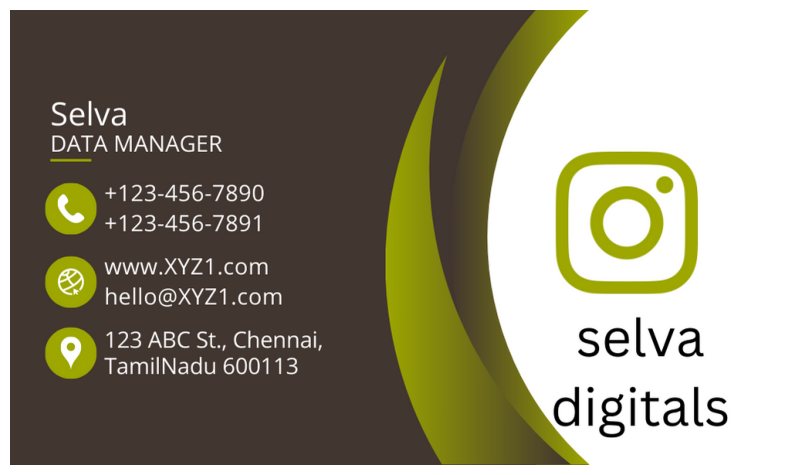

In [67]:
plt.rcParams['figure.figsize'] = (10,10)
plt.axis('off')
plt.imshow(image)

In [68]:
def img_to_binary(file):
    # Convert image data to binary format
    with open(file, 'rb') as file:
        binaryData = file.read()
    return binaryData


In [69]:
img_to_binary(saved_img)

b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03\xec\x00\x00\x02N\x08\x06\x00\x00\x00-z\x8d\xd9\x00\x00\x00\tpHYs\x00\x00.#\x00\x00.#\x01x\xa5?v\x00\x00\x04\x7fiTXtXML:com.adobe.xmp\x00\x00\x00\x00\x00<?xpacket begin=\'\xef\xbb\xbf\' id=\'W5M0MpCehiHzreSzNTczkc9d\'?>\n<x:xmpmeta xmlns:x=\'adobe:ns:meta/\'>\n<rdf:RDF xmlns:rdf=\'http://www.w3.org/1999/02/22-rdf-syntax-ns#\'>\n\n <rdf:Description rdf:about=\'\'\n  xmlns:Attrib=\'http://ns.attribution.com/ads/1.0/\'>\n  <Attrib:Ads>\n   <rdf:Seq>\n    <rdf:li rdf:parseType=\'Resource\'>\n     <Attrib:Created>2023-02-27</Attrib:Created>\n     <Attrib:ExtId>9ac1f0a6-56e7-49da-912d-41894ed0c0f1</Attrib:ExtId>\n     <Attrib:FbId>525265914179580</Attrib:FbId>\n     <Attrib:TouchType>2</Attrib:TouchType>\n    </rdf:li>\n   </rdf:Seq>\n  </Attrib:Ads>\n </rdf:Description>\n\n <rdf:Description rdf:about=\'\'\n  xmlns:dc=\'http://purl.org/dc/elements/1.1/\'>\n  <dc:title>\n   <rdf:Alt>\n    <rdf:li xml:lang=\'x-default\'>Creative Modern Business 

In [70]:
mycursor.execute('''CREATE TABLE IF NOT EXISTS card_data
                   (id INTEGER PRIMARY KEY AUTO_INCREMENT,
                    company_name TEXT,
                    card_holder TEXT,
                    designation TEXT,
                    mobile_number VARCHAR(50),
                    email TEXT,
                    website TEXT,
                    area TEXT,
                    city TEXT,
                    state TEXT,
                    pin_code VARCHAR(10),
                    image LONGBLOB
                    )''')

In [71]:
data = {"company_name" : [],
        "card_holder" : [],
        "designation" : [],
        "mobile_number" :[],
        "email" : [],
        "website" : [],
        "area" : [],
        "city" : [],
        "state" : [],
        "pin_code" : [],
        "image" : img_to_binary(saved_img)
        }

In [72]:
result

['Selva',
 'DATA MANAGER',
 '+123-456-7890',
 '+123-456-7891',
 'WWW XYZI.com',
 'hello@XYZ1.com',
 '123 ABC St , Chennai;',
 'selva',
 'TamilNadu 600113',
 'digitals']

In [73]:
def get_data(res):
    for ind,i in enumerate(res):

        # To get WEBSITE_URL
        if "www " in i.lower() or "www." in i.lower():
            data["website"].append(i)
        elif "WWW" in i:
            data["website"] = res[4] +"." + res[5]

        # To get EMAIL ID
        elif "@" in i:
            data["email"].append(i)

        # To get MOBILE NUMBER
        elif "-" in i:
            data["mobile_number"].append(i)
            if len(data["mobile_number"]) ==2:
                data["mobile_number"] = " & ".join(data["mobile_number"])

        # To get COMPANY NAME  
        elif ind == len(res)-1 :
            data["company_name"].append(i)

        # To get CARD HOLDER NAME
        elif ind == 0:
            data["card_holder"].append(i)

        # To get DESIGNATION
        elif ind == 1:
            data["designation"].append(i)

        # To get AREA
        if re.findall('^[0-9].+, [a-zA-Z]+',i):
            data["area"].append(i.split(',')[0])
        elif re.findall('[0-9] [a-zA-Z]+',i):
            data["area"].append(i)

        # To get CITY NAME
        match1 = re.findall('.+St , ([a-zA-Z]+).+', i)
        match2 = re.findall('.+St,, ([a-zA-Z]+).+', i)
        match3 = re.findall('^[E].*',i)
        if match1:
            data["city"].append(match1[0])
        elif match2:
            data["city"].append(match2[0])
        elif match3:
            data["city"].append(match3[0])

        # To get STATE
        state_match = re.findall('[a-zA-Z]{9} +[0-9]',i)
        if state_match:
                data["state"].append(i[:9])
        elif re.findall('^[0-9].+, ([a-zA-Z]+);',i):
            data["state"].append(i.split()[-1])
        if len(data["state"])== 2:
            data["state"].pop(0)

        # To get PINCODE        
        if len(i)>=6 and i.isdigit():
            data["pin_code"].append(i)
        elif re.findall('[a-zA-Z]{9} +[0-9]',i):
            data["pin_code"].append(i[10:])
get_data(result)

In [74]:
result

['Selva',
 'DATA MANAGER',
 '+123-456-7890',
 '+123-456-7891',
 'WWW XYZI.com',
 'hello@XYZ1.com',
 '123 ABC St , Chennai;',
 'selva',
 'TamilNadu 600113',
 'digitals']

In [75]:
company_name = result[0]
job_title = result[1]
mobile_number = result[2]
email = result[3]
website = result[4]
area = result[6]
city = result[7]
state = result[8]
pin_code = result[9]

In [76]:
def create_df(data):
    df = pd.DataFrame(data)
    return df
df = create_df(data)

In [77]:
df

,company_name,card_holder,designation,mobile_number,email,website,area,city,state,pin_code,image
0,digitals,Selva,DATA MANAGER,+123-456-7890 & +123-456-7891,hello@XYZ1.com,WWW XYZI.com,123 ABC St,Chennai,TamilNadu,600113,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...


In [78]:
for i,row in df.iterrows():
    #here %S means string values 
    sql = """INSERT INTO card_data(company_name,card_holder,designation,mobile_number,email,website,area,city,state,pin_code,image)
                VALUES (%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)"""
    mycursor.execute(sql, tuple(row))
    # the connection is not auto committed by default, so we must commit to save our changes
    mydb.commit()

In [79]:
mycursor.execute("SELECT card_holder FROM card_data")
results = mycursor.fetchall()
business_cards = {}
for row in results:
    business_cards[row[0]] = row[0]

mycursor.execute("select company_name,card_holder,designation,mobile_number,email,website,area,city,state,pin_code from card_data WHERE card_holder=%s",
                ("2.png",))
results = mycursor.fetchone()

In [80]:
# Extracting individual information
company_name = result[0]
card_holder =result[1]
designation = result[2]
mobile_number = result[3]
email = result[4]
website =  result[5]
area = result[6]
city = result[7]
state = result[8]
pin_code =  result[9]

# Printing individual information
print("Company Name:", company_name)
print("card_holder:",card_holder)
print("Designation:", designation)
print("Mobile Number:", mobile_number)
print("Email:", email)
print("Website:", website)
print("Area:", area)
print("City:", city)
print("State:", state)
print("Pin Code:", pin_code)

Company Name: Selva
card_holder: DATA MANAGER
Designation: +123-456-7890
Mobile Number: +123-456-7891
Email: WWW XYZI.com
Website: hello@XYZ1.com
Area: 123 ABC St , Chennai;
City: selva
State: TamilNadu 600113
Pin Code: digitals
